# I. Loading pictures and data

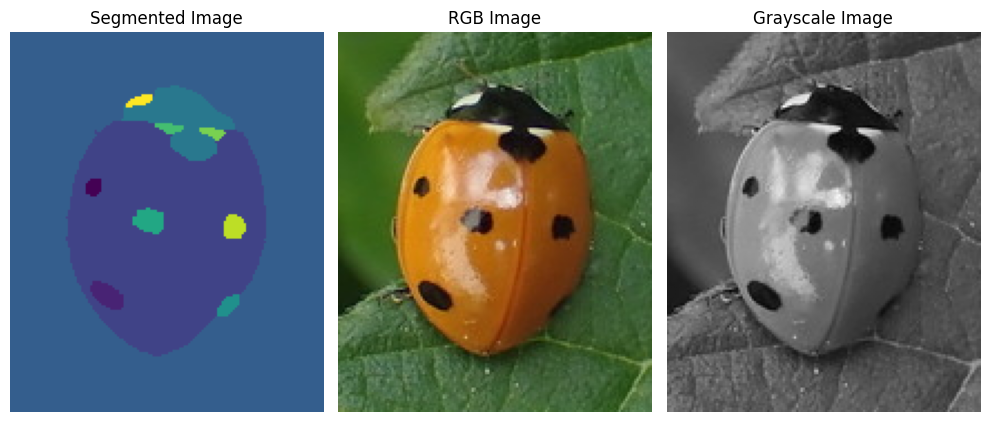

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Load CSV
labels = pd.read_csv('training_labels.csv')

# Paths to images
index = 1
segmentPath = f"D:/Github/ladybug/ladybug/im-{index:03d}_seg.png"
rgbPath = f"D:/Github/ladybug/ladybug/im-{index:03d}_im.png"

# Load images
indexed_image = Image.open(segmentPath) # palette/indexed mode
rgb_image = Image.open(rgbPath).convert("RGB")        # ensure RGB format
gray_image = rgb_image.convert("L")  

# Display both images side by side
plt.figure(figsize=(10, 5))

#Indexed image
plt.subplot(1, 3, 1)
plt.imshow(indexed_image)
plt.title("Segmented Image")
plt.axis("off")

# RGB image
plt.subplot(1, 3, 2)
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.axis("off")

# Grayscale image
plt.subplot(1, 3, 3)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.tight_layout()
plt.show()

# II. Isolating features
 In this section, we will isolate features from the images that could be usefull for classification. The idea is to automate the features extraction and avoid using deep learning, so we can explain the full process. Two of the most obvious features are the number of dot on the ladybug as well as the color of the ladybug. 

 Let's start by removing the background of the image since it does not seems to be relevant.

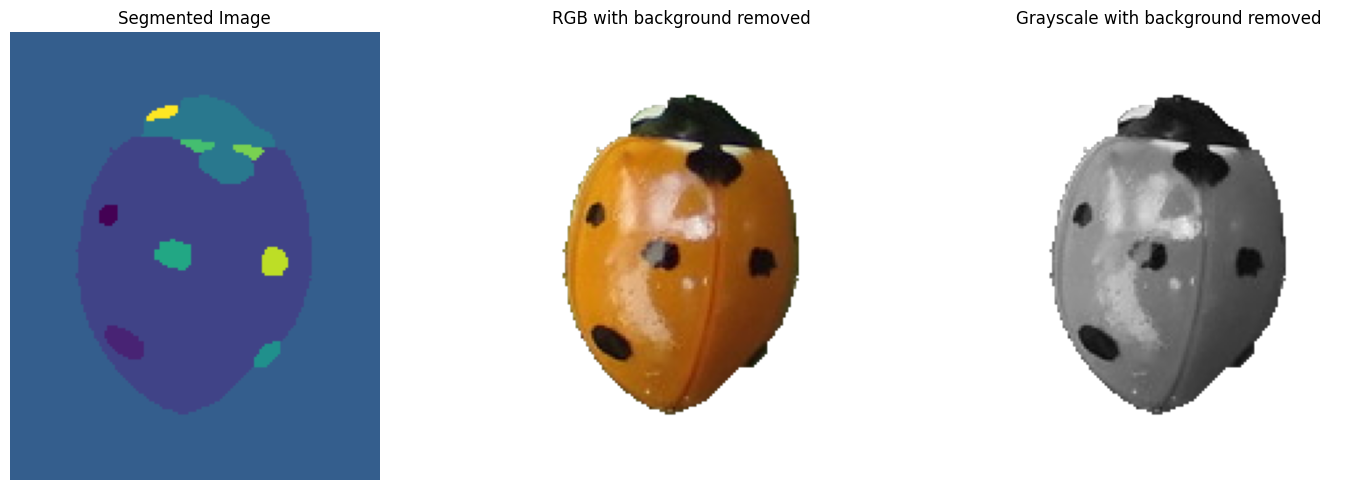

In [2]:
indexed_array = np.array(indexed_image)
rgb_array = np.array(rgb_image)
gray_array = np.array(gray_image)

# Get image dimensions
h, w = indexed_array.shape

# Get corner values
top_left = indexed_array[0, 0]
top_right = indexed_array[0, -1]
bottom_left = indexed_array[-1, 0]
bottom_right = indexed_array[-1, -1]

# Check if all corners match
if top_left == top_right == bottom_left == bottom_right:
    corner_value = top_left

    # Create transparency mask
    mask = indexed_array == corner_value

    # --- RGBA Image ---
    rgba_array = np.zeros((h, w, 4), dtype=np.uint8)
    rgba_array[:, :, :3] = rgb_array  # Copy RGB channels
    rgba_array[:, :, 3] = 255         # Full opacity
    rgba_array[mask, 3] = 0           # Transparent where mask is True

    # --- Grayscale with Alpha (LA) ---
    la_array = np.zeros((h, w, 2), dtype=np.uint8)
    la_array[:, :, 0] = gray_array
    la_array[:, :, 1] = 255
    la_array[mask, 1] = 0

    # Convert to images
    rgba_image = Image.fromarray(rgba_array, mode="RGBA")
    la_image = Image.fromarray(la_array, mode="LA")

    # Display
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(indexed_image)
    plt.title("Segmented Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(rgba_image)
    plt.title("RGB with background removed")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(la_image)
    plt.title("Grayscale with background removed")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Grayscale value at center (75, 105): 115


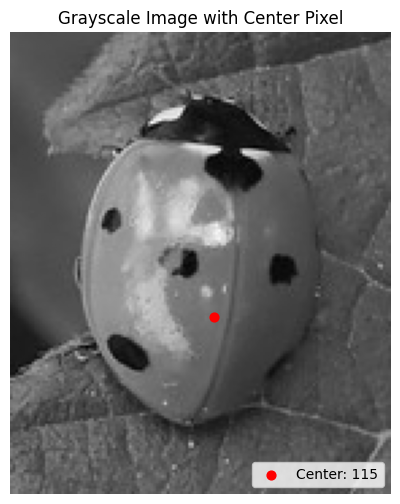

In [3]:
gray_image = Image.open(rgbPath).convert("L")
gray_array = np.array(gray_image)

# Get image dimensions
height, width = gray_array.shape
center_y = 105
center_x = 75


# Get center pixel value
center_value = gray_array[center_y, center_x]
print(f"Grayscale value at center ({center_x}, {center_y}): {center_value}")

# Display the grayscale image with a red dot at the center
plt.figure(figsize=(6, 6))
plt.imshow(gray_array, cmap="gray")
plt.scatter([center_x], [center_y], c='red', s=40, label=f'Center: {center_value}')
plt.title("Grayscale Image with Center Pixel")
plt.axis("off")
plt.legend(loc="lower right")
plt.show()

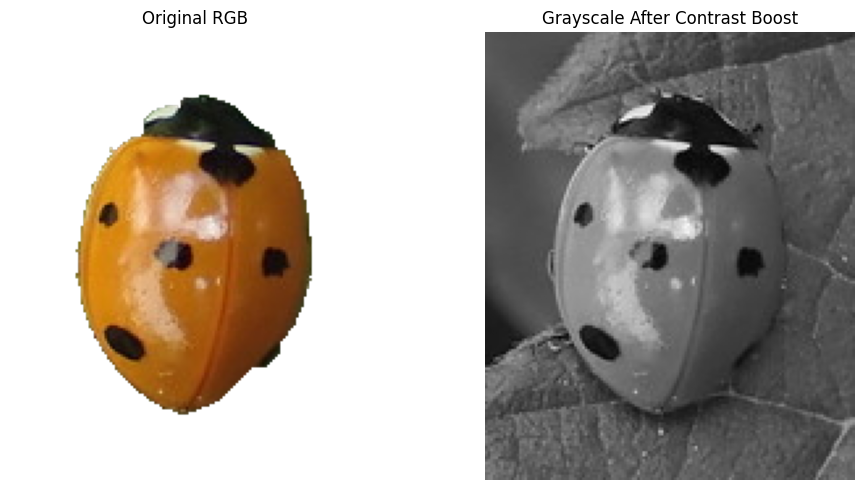

In [4]:
from PIL import ImageEnhance

# Load original RGB image
rgb_image = Image.fromarray(rgba_array, mode="RGBA")

# Increase contrast (factor > 1.0 increases contrast)
enhancer = ImageEnhance.Contrast(rgb_image)
high_contrast_rgb = enhancer.enhance(1)  # Try values like 1.5, 2.0, 2.5

# Convert to grayscale after contrast enhancement
gray_high_contrast = high_contrast_rgb.convert("L")

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gray_high_contrast, cmap='gray')
plt.title("Grayscale After Contrast Boost")
plt.axis("off")

plt.tight_layout()
plt.show()


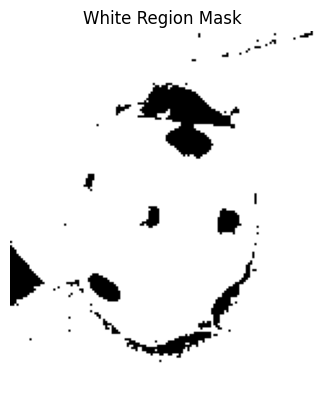

In [5]:
gray_array = np.array(gray_high_contrast)
white_mask = gray_array > 50  # adjust threshold as needed

# Visualize mask
plt.imshow(white_mask, cmap="gray")
plt.title("White Region Mask")
plt.axis("off")
plt.show()


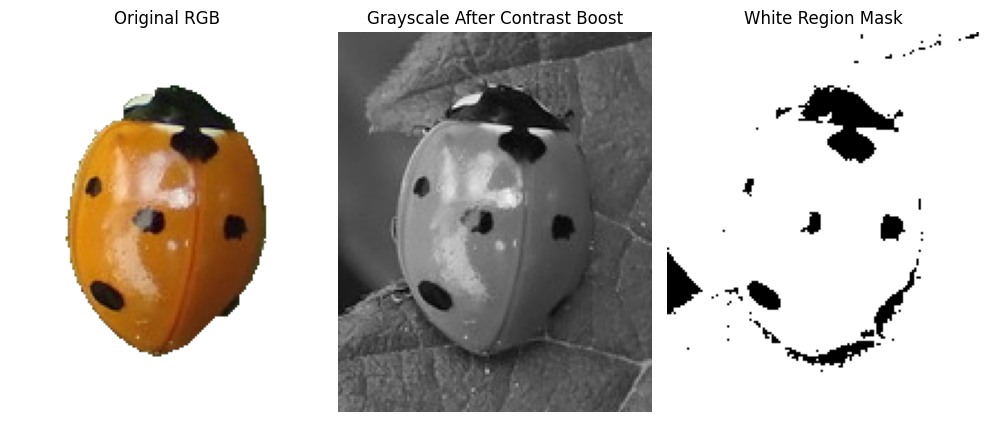

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gray_high_contrast, cmap='gray')
plt.title("Grayscale After Contrast Boost")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(white_mask, cmap="gray")
plt.title("White Region Mask")
plt.axis("off")

plt.tight_layout()
plt.show()